# Data Analysis - Reddit posts from people with depression
This notebook describes the data analysis of the dataset 'Depression: Reddit dataset (cleaned)' found in Kaggle (https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned).


In [ ]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msn
import scipy
import spacy
from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from wordcloud import WordCloud

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
# Loads the csv into a pandas dataframe.
#df = pd.read_csv('../Data/depression_dataset_reddit_cleaned.csv')
df = pd.read_csv('/content/drive/MyDrive/Enhance IT Data Science Course/Preparation (1)/BetterHelp/Data/depression_dataset_reddit_cleaned.csv')

The structure of the dataframe consists of two features:
* clean_text: Is the reddit post.
* is_depression: Indicates if the person who wrote the post has or not depression (1 = Depression, 0 = No depression)

The dataset consist of 7731 observations.

In [ ]:
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [ ]:
len(df)

7731

In [ ]:
# Feature types
df.dtypes

clean_text       object
is_depression     int64
dtype: object

In [ ]:
type(df.clean_text[0])

str

'clean_text' feature is string type. 'is_depression' feature is integer type. The following text is an example of one post in the 'clean_text' feature.

In [ ]:
df.clean_text[0]

'we understand that most people who reply immediately to an op with an invitation to talk privately mean only to help but this type of response usually lead to either disappointment or disaster it usually work out quite differently here than when you say pm me anytime in a casual social context we have huge admiration and appreciation for the goodwill and good citizenship of so many of you who support others here and flag inappropriate content even more so because we know that so many of you are struggling yourselves we re hard at work behind the scene on more information and resource to make it easier to give and get quality help here this is just a small start our new wiki page explains in detail why it s much better to respond in public comment at least until you ve gotten to know someone it will be maintained at r depression wiki private contact and the full text of the current version is below summary anyone who while acting a a helper invite or accepts private contact i e pm chat

## Dataset Completeness

In [ ]:
df.isnull().values.any()

False

In [ ]:
# Quantity of values in clean_text
df['clean_text'].map(type)

0       <class 'str'>
1       <class 'str'>
2       <class 'str'>
3       <class 'str'>
4       <class 'str'>
            ...      
7726    <class 'str'>
7727    <class 'str'>
7728    <class 'str'>
7729    <class 'str'>
7730    <class 'str'>
Name: clean_text, Length: 7731, dtype: object

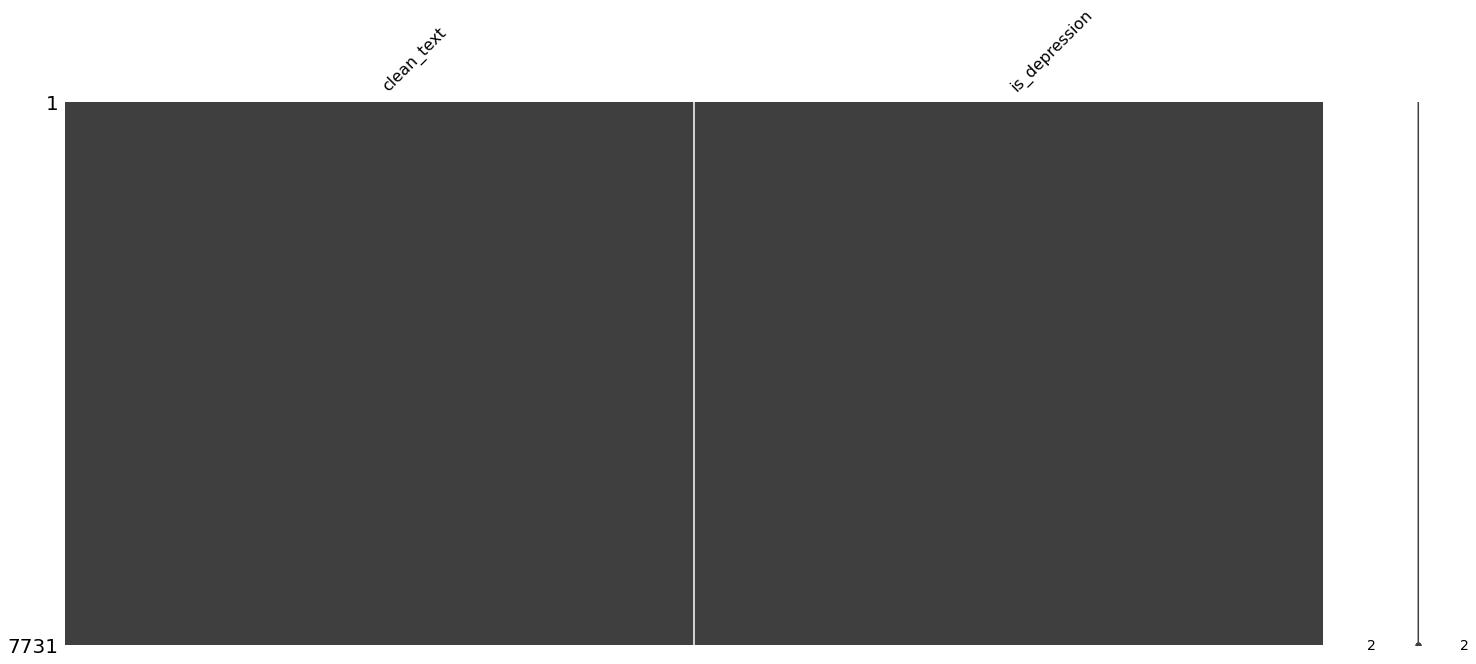

In [ ]:
msn.matrix(df)

In [ ]:
# Quantity of values whit no words in 'clean_text' feature.  
len(df.loc[df['clean_text'] == ''])

0

There are not missing values in the dataset.

## Distribution
The distribution of the reddit post of people who have and does not have depression is as follows:

In [ ]:
feelings = df['is_depression'].unique()
print(feelings)

[1 0]


([<matplotlib.patches.Wedge at 0x7f173901c6a0>,
 [Text(0.7188100013594028, 0.8326536986921367, 'Depressed'),
  Text(-0.7188100013594035, -0.8326536986921361, 'Not depresed')])

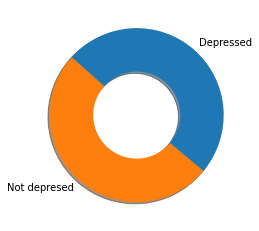

In [ ]:
feels = ['Depressed', 'Not depresed']
arr = []
for i in feelings:
    arr.append(len(df[df['is_depression'] == i]))
plt.pie(arr, shadow = True, labels = feels, wedgeprops=dict(width=0.5), startangle=-40)

In [ ]:
distribution = pd.DataFrame(columns = ['sentiment', 'quantity', 'percentage'])
for i, j in enumerate(feels):
    distribution = distribution.append({'sentiment' : j, 
                                        'quantity' : len(df[df['is_depression'] == feelings[i]]), 
                                        'percentage' : "{:.2%}".format(len(df[df['is_depression'] == feelings[i]]) / len(df))}, ignore_index = True)
distribution

,sentiment,quantity,percentage
0,Depressed,3831,49.55%
1,Not depresed,3900,50.45%


The distribution between the post from people with depression and the ones from the people who don´t is horizontal.

# Text length
The following section will describe the vehaviour of the length in the different reddit posts. The first step is to add a new feature named 'text_length' with the length of each of the texts. 

In [ ]:
df['text_length'] = [len(i) for i in df['clean_text']]

In [ ]:
df.head()

,clean_text,is_depression,text_length
0,we understand that most people who reply immed...,1,4535
1,welcome to r depression s check in post a plac...,1,2394
2,anyone else instead of sleeping more when depr...,1,236
3,i ve kind of stuffed around a lot in my life d...,1,510
4,sleep is my greatest and most comforting escap...,1,281


In [ ]:
min(df['text_length'])

3

In [ ]:
df.loc[df['text_length'] == min(df['text_length'])]

,clean_text,is_depression,text_length
2211,plz,1,3


The smallest text is just one three character word.

In [ ]:
max(df['text_length'])

19822

In [ ]:
df.loc[df['text_length'] == max(df['text_length'])]

,clean_text,is_depression,text_length
2089,it doesn t matter anymore i m going to copy an...,1,19822


The largest text has 19822 characters.

In [ ]:
round(np.mean(df['text_length']))

361

In [ ]:
df['text_length'].describe()

count     7731.000000
mean       361.383003
std        695.268030
min          3.000000
25%         58.000000
50%        110.000000
75%        362.500000
max      19822.000000
Name: text_length, dtype: float64

The length's mean is 361 with a standard deviation of 695. It looks like the length distribution is skewed.

In [ ]:
scipy.stats.mode(df['text_length'])

ModeResult(mode=array([60]), count=array([57]))

In [ ]:
np.median(df['text_length'])

110.0

The mode is 60 characters and the median is 110 characters.

### Plot of the length of each reddit post in the dataset

<function matplotlib.pyplot.show(*args, **kw)>

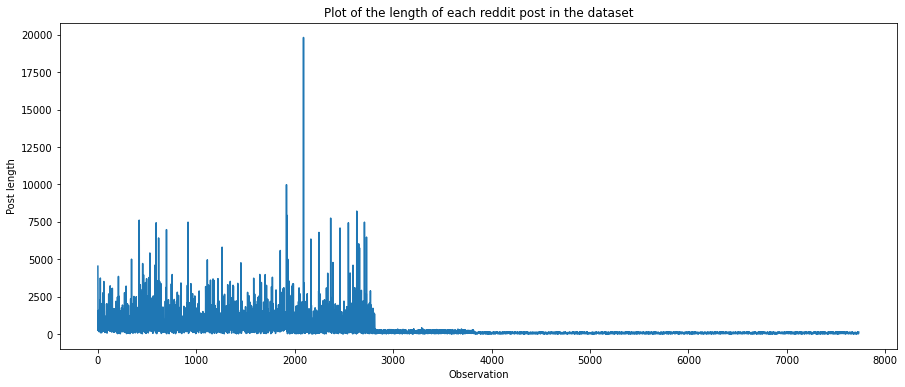

In [ ]:
plt.figure(figsize = (15, 6))
plt.plot(df['text_length'])
plt.title('Plot of the length of each reddit post in the dataset')
plt.ylabel('Post length')
plt.xlabel('Observation')
plt.show

### Density plot of the reddit posts length

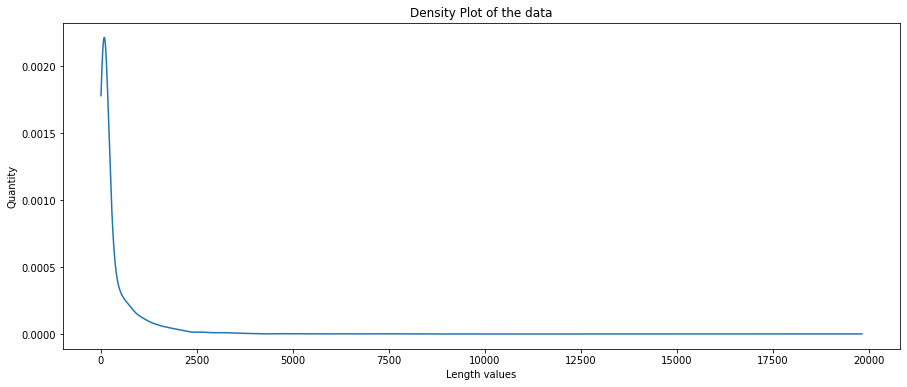

In [ ]:
density = scipy.stats.gaussian_kde(df['text_length'])
x = np.linspace(0,19822,3000)
y=density(x)

# Plot creation
plt.figure(figsize = (15, 6))
plt.plot(x, y)
plt.title("Density Plot of the data")
plt.ylabel('Quantity')
plt.xlabel('Length values')
plt.show()

Confirmed. As it was suposed, the length distribution is draatically skewed. Outliers should be identified.

### Quantity of observations who 'text_length' value is 2000 characters or less (no outliers).

In [ ]:
# Creation of a dataframe with no outliers.
dfno =  df.loc[df['text_length'] <= 2000]

In [ ]:
# Quantity of ovservations who 'text_length' value is 2000 characters or less.
len(dfno)

7519

([<matplotlib.patches.Wedge at 0x7f17369ff130>,
 [Text(0.7552866737148565, 0.7997137240967845, 'Depressed'),
  Text(-0.7552866737148568, -0.7997137240967843, 'Not depresed')])

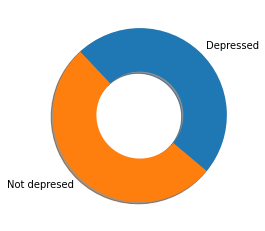

In [ ]:
# Distribution plot
arr = []
for i in feelings:
    arr.append(len(dfno[dfno['is_depression'] == i]))
plt.pie(arr, shadow = True, labels = feels, wedgeprops=dict(width=0.5), startangle=-40)

In [ ]:
# Distribution quantity and percentage
distribution = pd.DataFrame(columns = ['sentiment', 'quantity', 'percentage'])
for i, j in enumerate(feels):
    distribution = distribution.append({'sentiment' : j, 
                                        'quantity' : len(dfno[dfno['is_depression'] == feelings[i]]), 
                                        'percentage' : "{:.2%}".format(len(dfno[dfno['is_depression'] == feelings[i]]) / len(dfno))}, ignore_index = True)
distribution

,sentiment,quantity,percentage
0,Depressed,3619,48.13%
1,Not depresed,3900,51.87%


### Quantity of ovservations who 'text_length' value is more than 2000 characters (outliers).

In [ ]:
# Creation of a dataframe of the outliers.
dfo =  df.loc[df['text_length'] > 2000]

In [ ]:
# Quantity of ovservations who 'text_length' value is more than 2000 characters.
len(dfo)

212

([<matplotlib.patches.Wedge at 0x7f17369bce20>,
 [Text(-0.8426488874308757, 0.7070663706551935, 'Depressed'),
  Text(0.8426488874308756, -0.7070663706551936, 'Not depresed')])

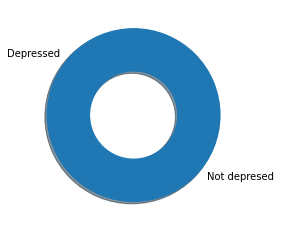

In [ ]:
# Distribution plot
arr = []
for i in feelings:
    arr.append(len(dfo[dfo['is_depression'] == i]))
plt.pie(arr, shadow = True, labels = feels, wedgeprops=dict(width=0.5), startangle=-40)

In [ ]:
# Distribution quantity and percentage
distribution = pd.DataFrame(columns = ['sentiment', 'quantity', 'percentage'])
for i, j in enumerate(feels):
    distribution = distribution.append({'sentiment' : j, 
                                        'quantity' : len(dfo[dfo['is_depression'] == feelings[i]]), 
                                        'percentage' : "{:.2%}".format(len(dfo[dfo['is_depression'] == feelings[i]]) / len(dfo))}, ignore_index = True)
distribution

,sentiment,quantity,percentage
0,Depressed,212,100.00%
1,Not depresed,0,0.00%


212 outliers found. All of them are from people who has depression. The distribution of the dataset after getting rid of the outliers is 48.13%/51.87%.  As the new distribution remains balanced, deletion of these observations is recommended.

In [ ]:
# Now df will be a copy of our dataset without outliers
df = dfno.copy()

## Data, pre-processing
First it is important to tokenize the words and do some pre-processing like:
* Lemmatization
* Tokenization
* Punctuation elimination
* Converting all letters to lowercase
* Numbers elimination
* Stopwords elimination


## Word frequency
This part of the anaysis is for checking the most frequent words in the dataset per class(label).

In [ ]:
nlp = spacy.load('en_core_web_lg')
nlp.max_length = 2500000

# Returns a list of lemmatized words using wordNetLemmatizer
def lemmatization(words):
    lemwn = WordNetLemmatizer()
    return [lemwn.lemmatize(x) for x in words]

# Returns a stemmed text.
def stemming(words):
    spanish_stemmer = SnowballStemmer('english')
    return spanish_stemmer.stem(words)

# Normalizing everything
def normalizer (data):
    text = []
    tknz = TweetTokenizer(strip_handles = True, reduce_len = True)
    
    # Tokenization by word
    for j in data:
        new_token = tknz.tokenize(j)
        for k in new_token:
            text.append(k)
            
    # Eliminates punctuation symbols
    nptext = []
    for token in text:
            new_token = re.sub("[^\w\s]", '', token)
            new_token = re.sub('^(?=[MDCLXVI])M*(C[MD]|D?C*)(X[CL]|L?X*)(I[XV]|V?I*)$', '', new_token)
            new_token = new_token.lower()
            new_token = re.sub('(?:^|\W)wa(?:$|\W)', 'was', new_token) #Found out 'wa' is very present in the reddit posts as a substitute of 'was'.
            if not new_token == '':
                nptext.append(new_token)
    # Eliminates numbers  
    nntext = [x for x in nptext if not x.isnumeric()]
    
    # Eliminates stop words
    stops = set(stopwords.words('english')) #are all lower case

    normtext = [token for token in nntext if token not in stops]
    
    # De-tokenize the list and puts everything into a string.
    string = ''
    string = ' '.join(normtext)
    
    # lemmatization
    lemtext = []
    for i, token in enumerate(nlp(string)):
        lemtext.append(token.lemma_)
    
    #print(lemtext)
    return lemtext


In [ ]:
## Creating FreqDist for whole BoW, keeping the 20 most common tokens
def freqdist (normtext):
    all_fdist = FreqDist(normtext).most_common(20)

    #print(FreqDist(normtext).items())
    return all_fdist

In [ ]:
def freqplot (all_fdist):
    ## Conversion to Pandas series via Python Dictionary for easier plotting
    all_fdist = pd.Series(dict(all_fdist))

    ## Setting figure, ax into variables
    fig, ax = plt.subplots(figsize=(10,10))

    ## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
    all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
    plt.xticks(rotation=30);
    plt.show()

In [ ]:
u_norm = normalizer(df['clean_text'])

In [ ]:
len(u_norm)

201140

### Most frequent words

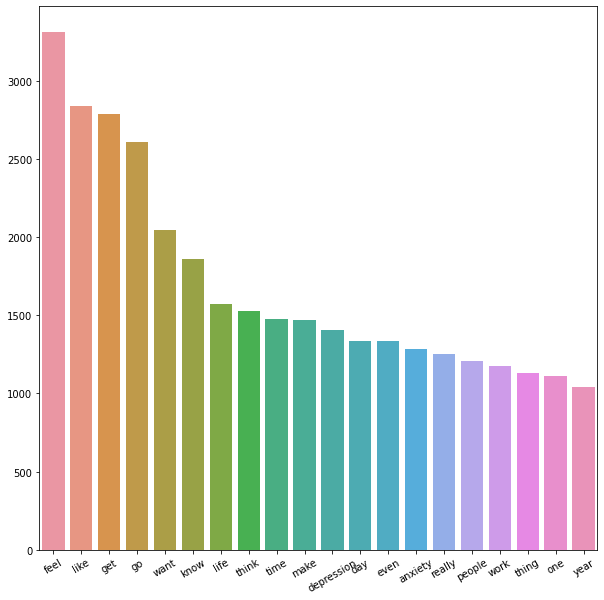

In [ ]:
u_fdist = freqdist(u_norm)
freqplot(u_fdist)

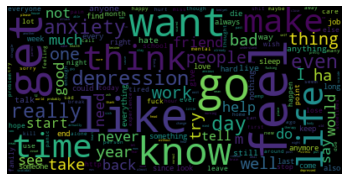

In [ ]:
u_fdist = FreqDist(u_norm)
cloud = WordCloud().generate_from_frequencies(u_fdist, 60)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most frequent words used by people with depression

In [ ]:
dep_norm = normalizer(df.loc[df['is_depression'] == 1, ['clean_text']].squeeze())

In [ ]:
len(dep_norm)

170401

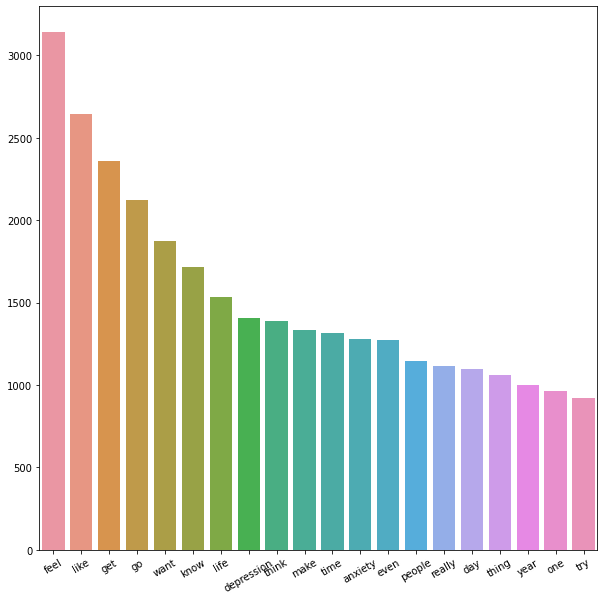

In [ ]:
dep_fdist = freqdist(dep_norm)
freqplot(dep_fdist)

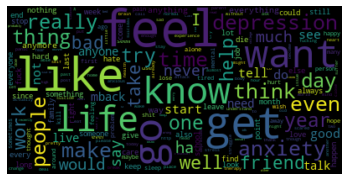

In [ ]:
dep_fdist = FreqDist(dep_norm)
cloud = WordCloud().generate_from_frequencies(dep_fdist, 60)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most frequent words used by people with no depression

In [ ]:
ndep_norm = normalizer(df.loc[df['is_depression'] == 0, ['clean_text']].squeeze())

In [ ]:
len(ndep_norm)

30739

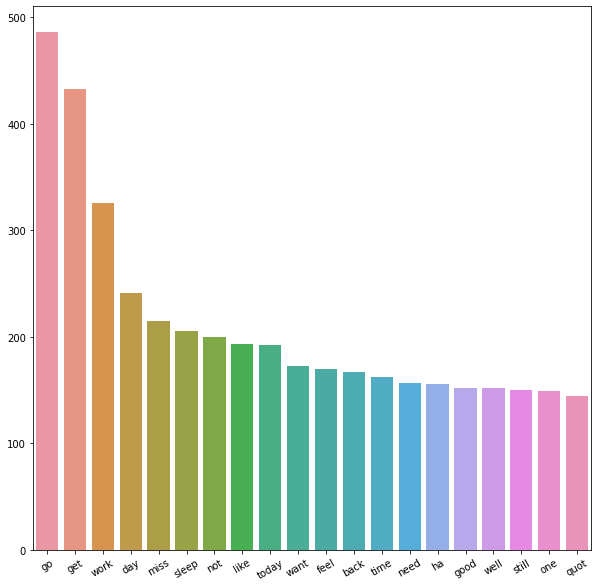

In [ ]:
ndep_fdist = freqdist(ndep_norm)
freqplot(ndep_fdist)

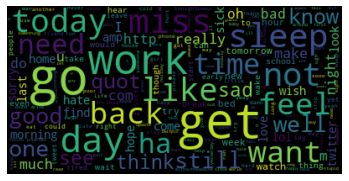

In [ ]:
ndep_fdist = FreqDist(ndep_norm)
cloud = WordCloud().generate_from_frequencies(ndep_fdist, 60)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
dep_top20 = FreqDist(dep_norm).most_common(20)

In [ ]:
ndep_top20 = FreqDist(ndep_norm).most_common(20)

In [ ]:
dep_list = []
[dep_list.append(i[0]) for i in dep_top20]

ndep_list = []
[ndep_list.append(i[0]) for i in ndep_top20]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
common_words =[]
for i in dep_list:
  if i in ndep_list:
    common_words.append(i)

In [ ]:
common_words

['feel', 'like', 'get', 'go', 'want', 'time', 'day', 'one']

In [ ]:
len(common_words)

8

8 of the most frequent words are in both twenty most frequent words used by people with depression as well as the twenty most frequent words used by people without depression. This is a risk for the performance of our models.